## Day 34 Lecture 2 Assignment

In this assignment, we will learn about gradient boosting. We will use a dataset of house information in Ames, Iowa, predicting sale price.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
house = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/houseprices.csv')
print(house.shape)
house.head()

(1460, 81)


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,...,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Check for nulls. Remove any columns with more than 100 nulls, then drop any remaining rows with nulls after that.

In [3]:
house.columns[house.isnull().sum() > 100]

Index(['lotfrontage', 'alley', 'fireplacequ', 'poolqc', 'fence',
       'miscfeature'],
      dtype='object')

In [4]:
df = house.drop(columns=['lotfrontage', 'alley', 'fireplacequ', 'poolqc', 'fence', 'miscfeature'])
df = df.dropna()
df.shape

(1338, 75)

One hot encode your categorical features using get_dummies.

In [5]:
# your work here
def dummify(df):
  categorical = df.select_dtypes(include='O')
  for col in categorical.columns:
    df = pd.concat([df, pd.get_dummies(df[col], drop_first=True, prefix=col)], axis=1)
    df = df.drop(columns=col)
  return df

In [6]:
df = dummify(df)
df

,id,mssubclass,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice,mszoning_FV,mszoning_RH,mszoning_RL,...,electrical_SBrkr,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA,functional_Maj2,functional_Min1,functional_Min2,functional_Mod,functional_Sev,functional_Typ,garagetype_Attchd,garagetype_Basment,garagetype_BuiltIn,garagetype_CarPort,garagetype_Detchd,garagefinish_RFn,garagefinish_Unf,garagequal_Fa,garagequal_Gd,garagequal_Po,garagequal_TA,garagecond_Fa,garagecond_Gd,garagecond_Po,garagecond_TA,paveddrive_P,paveddrive_Y,saletype_CWD,saletype_Con,saletype_ConLD,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial
0,1,60,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500,0,0,1,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,2,20,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500,0,0,1,...,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
2,3,60,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500,0,0,1,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
3,4,70,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000,0,0,1,...,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,5,60,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000,0,0,1,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,7917,6,5,1999,2000,0.0,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,1999.0,2,460,0,40,0,0,0,0,0,8,2007,175000,0,0,1,...,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1456,1457,20,13175,6,6,1978,1988,119.0,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,1978.0,2,500,349,0,0,0,0,0,0,2,2010,210000,0,0,1,...,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1457,1458,70,9042,7,9,1941,2006,0.0,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1941.0,1,252,0,60,0,0,0,0,2500,5,2010,266500,0,0,1,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1458,1459,20,9717,5,6,1950,1996,0.0,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1950.0,1,240,366,0,112,0,0,0,0,4,2010,142125,0,0,1,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


In [7]:
df = df.drop(columns='id')
df

,mssubclass,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,...,electrical_SBrkr,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA,functional_Maj2,functional_Min1,functional_Min2,functional_Mod,functional_Sev,functional_Typ,garagetype_Attchd,garagetype_Basment,garagetype_BuiltIn,garagetype_CarPort,garagetype_Detchd,garagefinish_RFn,garagefinish_Unf,garagequal_Fa,garagequal_Gd,garagequal_Po,garagequal_TA,garagecond_Fa,garagecond_Gd,garagecond_Po,garagecond_TA,paveddrive_P,paveddrive_Y,saletype_CWD,saletype_Con,saletype_ConLD,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial
0,60,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500,0,0,1,0,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,20,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
2,60,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500,0,0,1,0,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
3,70,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000,0,0,1,0,...,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,60,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000,0,0,1,0,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,7917,6,5,1999,2000,0.0,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,1999.0,2,460,0,40,0,0,0,0,0,8,2007,175000,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1456,20,13175,6,6,1978,1988,119.0,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,1978.0,2,500,349,0,0,0,0,0,0,2,2010,210000,0,0,1,0,...,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1457,70,9042,7,9,1941,2006,0.0,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1941.0,1,252,0,60,0,0,0,0,2500,5,2010,266500,0,0,1,0,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1458,20,9717,5,6,1950,1996,0.0,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1950.0,1,240,366,0,112,0,0,0,0,4,2010,142125,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


Take a look at your outcome variable. It is highly skewed, and has a few very rare large outliers.

Let's try log transforming the y variable.

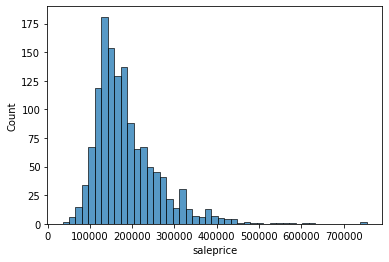

In [8]:
# your work here
sns.histplot(df.saleprice)
plt.show()

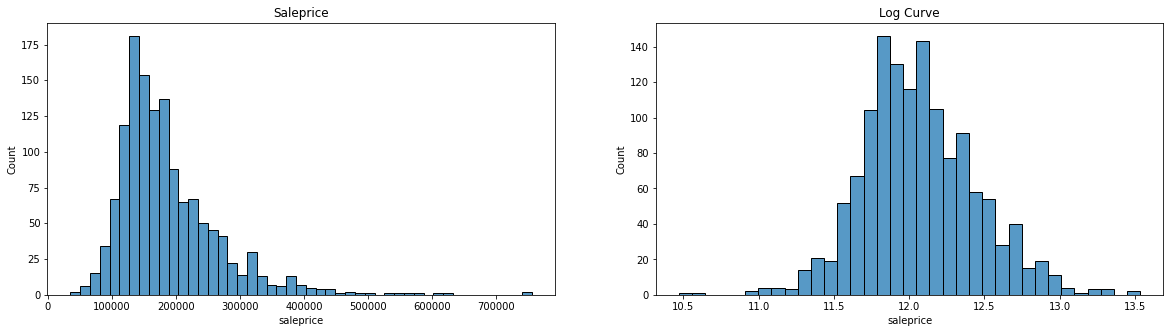

In [9]:
#log transformation
plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
plt.title('Saleprice')
sns.histplot(df['saleprice'])
plt.subplot(1,2,2)
log_df = df['saleprice'].apply(np.log)
sns.histplot(log_df)
plt.title('Log Curve')
plt.show()

In [10]:
y = log_df

We know that there are some rare large values. We can make sure that the training and test sets have about the same distribution by stratifying the train-test split.

Split your training and test sets, with a test size of 0.2. Use the given helper function to stratify the continuous outcome. Remember that the outcome variable is now the **log of sale price**.

In [11]:
def binned(y, num_bins):
    # Creates an object to put in the stratify keyword in train_test_split
    # Specify number of bins to separate your y variable
    ymin, ymax = y.min(), y.max()
    bins = np.linspace(ymin, ymax, num_bins+1)[:-1]
    y_binned = np.digitize(y, bins)
    return y_binned

In [12]:
# your work here
from sklearn.model_selection import train_test_split

x = df.drop(columns='saleprice')

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, stratify=binned(y, 2))

In [13]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 1459
Columns: 226 entries, mssubclass to salecondition_Partial
dtypes: float64(2), int64(33), uint8(191)
memory usage: 625.9 KB


Create a Gradient Boosting Regressor model. Measure the MAE (Mean Absolute Error) for the training and testing sets.

In [14]:
# your work here
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

gbr = GradientBoostingRegressor(learning_rate = .8, max_depth=4, n_iter_no_change=10, n_estimators=1000)
gbr.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.8, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=10, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Create a grid search. Try varying subsample, learning rate, and max features. Use MAE as your scoring metric.

In [15]:
# your work here
from sklearn.model_selection import GridSearchCV

grid = {'subsample': [.5, .7, .9], 'learning_rate': [.6, .4, .1], 'max_features': [5, 10, 15]}

gbr_cv = GridSearchCV(GradientBoostingRegressor(max_depth=4, n_iter_no_change=10), grid, cv=5, scoring='neg_mean_absolute_error')
gbr_cv.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=4,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...nge=10,
                     

In [16]:
print('Training MAE: ', abs(gbr_cv.score(x_train, y_train)))
print('Testing MAE: ', abs(gbr_cv.score(x_test, y_test)))


Training MAE:  0.05562715381233096
Testing MAE:  0.0792297640821644


Create residual plots of the training and test sets and interpret your results.

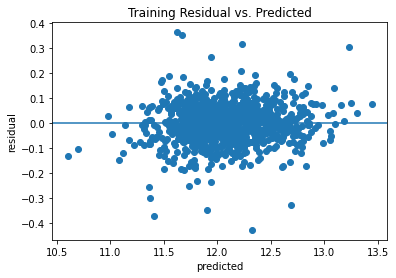

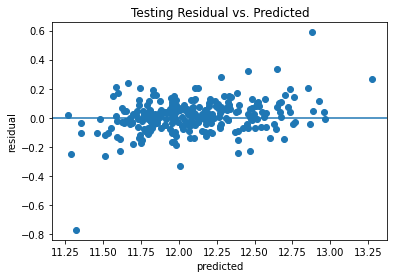

In [17]:
# your work here
train_preds = gbr_cv.predict(x_train)
train_resid = y_train - train_preds
test_preds = gbr_cv.predict(x_test)
test_resid = y_test - test_preds

plt.scatter(train_preds, train_resid)
plt.xlabel('predicted')
plt.ylabel('residual')
plt.axhline(y=0)
plt.title('Training Residual vs. Predicted')
plt.show()

plt.scatter(y_test, test_resid)
plt.xlabel('predicted')
plt.ylabel('residual')
plt.axhline(y=0)
plt.title('Testing Residual vs. Predicted')
plt.show()


The plots seem to be very similar. This suggest little overfitting